In [3]:
####################################################################################################
# Abe Tishelman-Charny
# abraham.tishelman.charny@cern.ch
# 16 April 2020
#
# The purpose of this module is to create 10x10 arrays of photon rec hit images 
# for prompt and fake photons in order to feed into a CNN. 
# This module also trains the CNN with prompt and fake images and outputs signal and fake efficiencies.

# Thank you: 
# https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5
#####################################################################################################

# !pip install --user uproot # shouldn't be necessary 

import ROOT
from ROOT import TFile, gROOT
import numpy as np 
import uproot

gROOT.SetBatch(1)

In [4]:
##-- Get input file
input_file = "/eos/user/a/atishelm/ntuples/PhotonCNN/20-40CheckDetID_Hadded/20-40_Hadded.root"
f = TFile(input_file)
Prompt_t = f.Get("photonViewDumper/trees/promptPhotons") 
Fake_t = f.Get("photonViewDumper/trees/fakePhotons") 

In [5]:
width = 10 # width of recHit window

In [6]:
##-- Get num rec hits and names of branches to use 

num_rec_hits = int(float(width)*float(width))

DOF1s, DOF2s, DOF3s, irechitEs = [], [], [], []

for i in range(int(num_rec_hits)):
    tmp_name = "DOF1s_"
    tmp_name += str(i)
    DOF1s.append(tmp_name)

    tmp_name = "DOF2s_"
    tmp_name += str(i)
    DOF2s.append(tmp_name)

    tmp_name = "DOF3s_"
    tmp_name += str(i)
    DOF3s.append(tmp_name)

    tmp_name = "recHit_"
    tmp_name += str(i)
    irechitEs.append(tmp_name)

In [23]:
##-- Params for running through output ntuples from flashgg event dumper

maxPhotons = 1000 # Number of photons to run over for each tree: Prompt and Fake. -1 for all photons  
doPrompts = 1
doFakes = 1
plotFullMaps = 1 # make plots of total energy and occupancy for EB, EE for Prompts and Fakes 
Pct1, Pct2 = 0.675, 0.9 # Pct1 is percentage of images in both Prompt and Fake used for Training set
# Pct2 - Pct1 = % used for Validation set
# Remaining: Used for test set 
printPct = 25 # Print progress for rec hit every printPct percent 
##-------------------- 

X_train_EB = []
Y_train_EB = []

X_valid_EB = []
Y_valid_EB = []

X_test_EB_Prompts = []
Y_test_EB_Prompts = [] 
X_test_EB_Fakes = []
Y_test_EB_Fakes = [] 

X_train_EE = []
Y_train_EE = []

X_valid_EE = []
Y_valid_EE = []

X_test_EE_Prompts = []
Y_test_EE_Prompts = [] 
X_test_EE_Fakes = []
Y_test_EE_Fakes = [] 

EB_width = 170 # ieta: -85 to 85 
EB_height = 360 # iphi: 0 to 360 

EE_width = 100 # ix: 0-100
EE_height = 100 # iy: 0-100

FullMap_SigEB_rechits = [ [ 0 for i in range(EB_height) ] for j in range(EB_width) ]
FullMap_NSigEB_rechits = [ [ 0 for i in range(EB_height) ] for j in range(EB_width) ]

FullMap_FakeEB_rechits = [ [ 0 for i in range(EB_height) ] for j in range(EB_width) ]
FullMap_NFakeEB_rechits = [ [ 0 for i in range(EB_height) ] for j in range(EB_width) ]

FullMap_SigEE_rechits = [ [ 0 for i in range(EE_height) ] for j in range(EE_width) ]
FullMap_NSigEE_rechits = [ [ 0 for i in range(EE_height) ] for j in range(EE_width) ]

FullMap_FakeEE_rechits = [ [ 0 for i in range(EE_height) ] for j in range(EE_width) ]
FullMap_NFakeEE_rechits = [ [ 0 for i in range(EE_height) ] for j in range(EE_width) ]

BadDOF3RawIds = open("BadDOF3RawIds.txt","w") 
BadrelDOFRawIds = open("BadrelDOFRawIds.txt","w")

nPromptPhotons, nFakePhotons = Prompt_t.GetEntries(), Fake_t.GetEntries()

print('Number of prompt photons in file:', nPromptPhotons)
print('Number of fake photons in file:', nFakePhotons)

##-- Run on all photons, unless specified 
if(maxPhotons==-1):
    PromptPhotonstoRun = nPromptPhotons
    FakePhotonstoRun = nFakePhotons
else:
    PromptPhotonstoRun = maxPhotons 
    FakePhotonstoRun = maxPhotons

print('Running on %s prompt photons'%PromptPhotonstoRun)    
print('Running on %s fake photons'%FakePhotonstoRun)    
    
print('Opening file...')
file = uproot.open(input_file)
print('Opened file: %s'%input_file)

if(doPrompts):
    promptTree = file['photonViewDumper/trees/promptPhotons']
    print('Getting branches...')
    promptBranches = promptTree.arrays(namedecode='utf-8')
    print('Got branches!')

    promptPhoObjDOF1Vals = promptBranches["DOF1"]
    promptPhoObjDOF2Vals = promptBranches["DOF2"]
    promptPhoObjDOF3Vals = promptBranches["DOF3"]

    ##-- Prompts     
    # initialize an array for each photon 
    # loop rec hits 
    # for each rec hit, fill appropriate array spot for all photons 
    # append all arrays to train, validate, or test data::: sort based on EB,EE

    # Create array for each photon 
    allPromptImages = []
    allPromptImagesDOF3 = []
    for iPho in range(PromptPhotonstoRun): #### make sure this is set properly.......
        allPromptImages.append( 
                [ [ 0 for i in range(width) ] for j in range(width) ]
            )
        allPromptImagesDOF3.append(-99)

    for i_recHit in range(0,num_rec_hits):
        if(i_recHit%10 == 0): print('On rechit: %s/%s'%(str(i_recHit),str(num_rec_hits)))
        DOF1BranchName = DOF1s[i_recHit]
        DOF2BranchName = DOF2s[i_recHit]
        DOF3BranchName = DOF3s[i_recHit]
        recHitBranchName = irechitEs[i_recHit]
        recHitRawIdName = "rawId_%s"%(str(i_recHit))

        DOF1Vals = promptBranches[DOF1BranchName]
        DOF2Vals = promptBranches[DOF2BranchName]
        DOF3Vals = promptBranches[DOF3BranchName]
        recHitVals = promptBranches[recHitBranchName]
        recHitRawIdVals = promptBranches[recHitRawIdName]

        for iPho in range(0,PromptPhotonstoRun):
            if(iPho%float(PromptPhotonstoRun/(printPct)) == 0): print('[ %s %% ] --- On Prompt Photon %s/%s'%(str(float(iPho)*100./float(PromptPhotonstoRun)),str(iPho),str(PromptPhotonstoRun)))                
            recHitDOF1 = DOF1Vals[iPho]
            recHitDOF2 = DOF2Vals[iPho]
            recHitDOF3 = DOF3Vals[iPho]
            recHitVal = recHitVals[iPho]
            promptPhoDOF1 = promptPhoObjDOF1Vals[iPho]
            promptPhoDOF2 = promptPhoObjDOF2Vals[iPho]
            promptPhoDOF3 = promptPhoObjDOF3Vals[iPho]

            if(recHitDOF1 == -9999): continue 

            rel_dof1 = int((recHitDOF1 - promptPhoDOF1)) + 4 
            rel_dof2 = int((recHitDOF2 - promptPhoDOF2)) + 4  

            if(recHitDOF3!=0 and recHitDOF3!=-1 and recHitDOF3!=1 and recHitDOF3!=-9999): 
                RawId = recHitRawIdVals[iPho]
                BadDOF3RawIds.write("%s\n"%(str(RawId)))
                continue 

            if(rel_dof2 < 0) or (rel_dof1 < 0) or (rel_dof2 >= 10) or (rel_dof1 >= 10):
                RawId = recHitRawIdVals[iPho]
                BadrelDOFRawIds.write("%s\n"%(str(RawId))) 
                continue                 

            allPromptImages[iPho][rel_dof1][rel_dof2] += recHitVal # update each Photon's i_recHit 
            if(allPromptImagesDOF3[iPho]==-99): allPromptImagesDOF3[iPho] = promptPhoDOF3
            if(plotFullMaps):
                if(promptPhoDOF3 == 0):
                    FullMap_SigEB_rechits[int(recHitDOF1)+84][int(recHitDOF2)-1] += recHitVal
                    FullMap_NSigEB_rechits[int(recHitDOF1)+84][int(recHitDOF2)-1] += 1
                else:
                    FullMap_SigEE_rechits[int(recHitDOF1)-1][int(recHitDOF2)-1] += recHitVal
                    FullMap_NSigEE_rechits[int(recHitDOF1)-1][int(recHitDOF2)-1] += 1                
         
    ##-- Distribute images among Training, Validation and Test datasets                                     
    for img_i,image in enumerate(allPromptImages):
        imgDOF3 = allPromptImagesDOF3[img_i]

        # EB 
        if imgDOF3 == 0:
            if(img_i < Pct1*PromptPhotonstoRun):
                X_train_EB.append(image)
                Y_train_EB.append(1) # 1 = signal 
#                 Y_train_EB.append([1,0]) # 1 = signal 
            elif( (img_i > Pct1*PromptPhotonstoRun) and (img_i <= Pct2*PromptPhotonstoRun) ):
                X_valid_EB.append(image)
                Y_valid_EB.append(1)
#                 Y_valid_EB.append([1,0])
            else:
                X_test_EB_Prompts.append(image)
                Y_test_EB_Prompts.append(1)
#                 Y_test_EB_Prompts.append([1,0])

        # EE
        elif imgDOF3 == -1 or imgDOF3 == 1:
            if(img_i < Pct1*PromptPhotonstoRun):
                X_train_EE.append(image)
                Y_train_EE.append(1) # 1 = signal 
            elif( (img_i > Pct1*PromptPhotonstoRun) and (img_i <= Pct2*PromptPhotonstoRun) ):
                X_valid_EE.append(image)
                Y_valid_EE.append(1)
            else:
                X_test_EE_Prompts.append(image)
                Y_test_EE_Prompts.append(1)

        else:
            print('ERROR')
            print('image DOF3 is neither EB nor EE.')
            print('Exiting')
            exit(0)


if(doFakes):
    #####
    # Fakes
    print('On Fakes')

    fakeTree = file['photonViewDumper/trees/fakePhotons']
    fakeBranches = fakeTree.arrays(namedecode='utf-8')

    fakePhoObjDOF1Vals = fakeBranches["DOF1"]
    fakePhoObjDOF2Vals = fakeBranches["DOF2"]
    fakePhoObjDOF3Vals = fakeBranches["DOF3"]

    # Create array for each Photon
    allFakeImages = []
    allFakeImagesDOF3 = []
    for iPho in range(FakePhotonstoRun):
        allFakeImages.append(
                [ [ 0 for i in range(width) ] for j in range(width) ]
            )
        allFakeImagesDOF3.append(-99)

    for i_recHit in range(0,num_rec_hits):
        if(i_recHit%10 == 0): print('On rechit: %s/%s'%(str(i_recHit),str(num_rec_hits)))
        DOF1BranchName = DOF1s[i_recHit]
        DOF2BranchName = DOF2s[i_recHit]
        DOF3BranchName = DOF3s[i_recHit]
        recHitBranchName = irechitEs[i_recHit]
        recHitRawIdName = "rawId_%s"%(str(i_recHit))

        DOF1Vals = fakeBranches[DOF1BranchName]
        DOF2Vals = fakeBranches[DOF2BranchName]
        DOF3Vals = fakeBranches[DOF3BranchName]
        recHitVals = fakeBranches[recHitBranchName]
        recHitRawIdVals = fakeBranches[recHitRawIdName]

        for iPho in range(FakePhotonstoRun):
            if(iPho%float(FakePhotonstoRun/printPct) == 0): print('[ %s %% ] --- On Fake Photon: %s/%s'%(str(float(iPho)*100./float(FakePhotonstoRun)),str(iPho),str(FakePhotonstoRun)))
            recHitDOF1 = DOF1Vals[iPho]
            recHitDOF2 = DOF2Vals[iPho]
            recHitDOF3 = DOF3Vals[iPho]
            recHitVal = recHitVals[iPho]
            fakePhoDOF1 = fakePhoObjDOF1Vals[iPho]
            fakePhoDOF2 = fakePhoObjDOF2Vals[iPho]
            fakePhoDOF3 = fakePhoObjDOF3Vals[iPho]

            if(recHitDOF1 == -9999): continue # in this case,

            rel_dof1 = int(recHitDOF1 - fakePhoDOF1) + 4 
            rel_dof2 = int(recHitDOF2 - fakePhoDOF2) + 4 

            if(recHitDOF3!=0 and recHitDOF3!=-1 and recHitDOF3!=1 and recHitDOF3!=-9999): 
                RawId = recHitRawIdVals[iPho]
                BadDOF3RawIds.write("%s\n"%(str(RawId)))
                continue 

            if(rel_dof2 < 0) or (rel_dof1 < 0) or (rel_dof2 >= 10) or (rel_dof1 >= 10):
                RawId = recHitRawIdVals[iPho]
                BadrelDOFRawIds.write("%s\n"%(str(RawId))) 
                continue  

            allFakeImages[iPho][rel_dof1][rel_dof2] += recHitVal # update each event's i_recHit 
            if(allFakeImagesDOF3[iPho]==-99): allFakeImagesDOF3[iPho] = fakePhoDOF3
            if(plotFullMaps):
#                 print("int(recHitDOF1):",int(recHitDOF1))
#                 print("int(recHitDOF2):",int(recHitDOF2))
                if(fakePhoDOF3 == 0):
                    FullMap_FakeEB_rechits[int(recHitDOF1)+84][int(recHitDOF2)-1] += recHitVal
                    FullMap_NFakeEB_rechits[int(recHitDOF1)+84][int(recHitDOF2)-1] += 1
                else:
#                     print("promptPhoDOF3:",promptPhoDOF3)
                    if(int(recHitDOF1)>100) or int(recHitDOF2>100):
                        print("For some reason, DOF3 is not 0, but DOF1 or 2 is greater than 100...")
                        print("Skipping for now, but this needs to be understood")
#                         print("int(recHitDOF1):",int(recHitDOF1))
#                         print("int(recHitDOF2):",int(recHitDOF2))
                        continue
                    FullMap_FakeEE_rechits[int(recHitDOF1)-1][int(recHitDOF2)-1] += recHitVal
                    FullMap_NFakeEE_rechits[int(recHitDOF1)-1][int(recHitDOF2)-1] += 1             
            

    ##-- Distribute images among Training, Validation and Test datasets 
    for img_i,image in enumerate(allFakeImages):
        imgDOF3 = allFakeImagesDOF3[img_i]

        # EB 
        if imgDOF3 == 0:
            if(img_i < Pct1*FakePhotonstoRun):
                X_train_EB.append(image)
                Y_train_EB.append(0) # 1 = signal 
#                 Y_train_EB.append([0,1]) # 1 = signal 
            elif( (img_i > Pct1*FakePhotonstoRun) and (img_i <= Pct2*FakePhotonstoRun) ):
                X_valid_EB.append(image)
                Y_valid_EB.append(0)
#                 Y_valid_EB.append([0,1])
            else:
                X_test_EB_Fakes.append(image)
                Y_test_EB_Fakes.append(0)
#                 Y_test_EB_Fakes.append([0,1])

        # EE
        elif imgDOF3 == -1 or imgDOF3 == 1:
            if(img_i < Pct1*FakePhotonstoRun):
                X_train_EE.append(image)
                Y_train_EE.append(0) # 1 = signal 
#                 Y_train_EE.append([0,1]) # 1 = signal 
            elif( (img_i > Pct1*FakePhotonstoRun) and (img_i <= Pct2*FakePhotonstoRun) ):
                X_valid_EE.append(image)
                Y_valid_EE.append(0)
#                 Y_valid_EE.append([0,1])
            else:
                X_test_EE_Fakes.append(image)
                Y_test_EE_Fakes.append(0)
#                 Y_test_EE_Fakes.append([0,1])

        else:
            print('ERROR')
            print('image DOF3 is neither EB nor EE.')
            print('Exiting')
            exit(0)
   
 
BadDOF3RawIds.close()
BadrelDOFRawIds.close()


print('DONE')

Number of prompt photons in file: 488383
Number of fake photons in file: 378409
Running on 1000 prompt photons
Running on 1000 fake photons
Opening file...
Opened file: /eos/user/a/atishelm/ntuples/PhotonCNN/20-40CheckDetID_Hadded/20-40_Hadded.root
Getting branches...
Got branches!
On rechit: 0/100
[ 0.0 % ] --- On Prompt Photon 0/1000
[ 4.0 % ] --- On Prompt Photon 40/1000
[ 8.0 % ] --- On Prompt Photon 80/1000
[ 12.0 % ] --- On Prompt Photon 120/1000
[ 16.0 % ] --- On Prompt Photon 160/1000
[ 20.0 % ] --- On Prompt Photon 200/1000
[ 24.0 % ] --- On Prompt Photon 240/1000
[ 28.0 % ] --- On Prompt Photon 280/1000
[ 32.0 % ] --- On Prompt Photon 320/1000
[ 36.0 % ] --- On Prompt Photon 360/1000
[ 40.0 % ] --- On Prompt Photon 400/1000
[ 44.0 % ] --- On Prompt Photon 440/1000
[ 48.0 % ] --- On Prompt Photon 480/1000
[ 52.0 % ] --- On Prompt Photon 520/1000
[ 56.0 % ] --- On Prompt Photon 560/1000
[ 60.0 % ] --- On Prompt Photon 600/1000
[ 64.0 % ] --- On Prompt Photon 640/1000
[ 68.0 % ]

[ 84.0 % ] --- On Prompt Photon 840/1000
[ 88.0 % ] --- On Prompt Photon 880/1000
[ 92.0 % ] --- On Prompt Photon 920/1000
[ 96.0 % ] --- On Prompt Photon 960/1000
[ 0.0 % ] --- On Prompt Photon 0/1000
[ 4.0 % ] --- On Prompt Photon 40/1000
[ 8.0 % ] --- On Prompt Photon 80/1000
[ 12.0 % ] --- On Prompt Photon 120/1000
[ 16.0 % ] --- On Prompt Photon 160/1000
[ 20.0 % ] --- On Prompt Photon 200/1000
[ 24.0 % ] --- On Prompt Photon 240/1000
[ 28.0 % ] --- On Prompt Photon 280/1000
[ 32.0 % ] --- On Prompt Photon 320/1000
[ 36.0 % ] --- On Prompt Photon 360/1000
[ 40.0 % ] --- On Prompt Photon 400/1000
[ 44.0 % ] --- On Prompt Photon 440/1000
[ 48.0 % ] --- On Prompt Photon 480/1000
[ 52.0 % ] --- On Prompt Photon 520/1000
[ 56.0 % ] --- On Prompt Photon 560/1000
[ 60.0 % ] --- On Prompt Photon 600/1000
[ 64.0 % ] --- On Prompt Photon 640/1000
[ 68.0 % ] --- On Prompt Photon 680/1000
[ 72.0 % ] --- On Prompt Photon 720/1000
[ 76.0 % ] --- On Prompt Photon 760/1000
[ 80.0 % ] --- On Promp

On rechit: 40/100
[ 0.0 % ] --- On Prompt Photon 0/1000
[ 4.0 % ] --- On Prompt Photon 40/1000
[ 8.0 % ] --- On Prompt Photon 80/1000
[ 12.0 % ] --- On Prompt Photon 120/1000
[ 16.0 % ] --- On Prompt Photon 160/1000
[ 20.0 % ] --- On Prompt Photon 200/1000
[ 24.0 % ] --- On Prompt Photon 240/1000
[ 28.0 % ] --- On Prompt Photon 280/1000
[ 32.0 % ] --- On Prompt Photon 320/1000
[ 36.0 % ] --- On Prompt Photon 360/1000
[ 40.0 % ] --- On Prompt Photon 400/1000
[ 44.0 % ] --- On Prompt Photon 440/1000
[ 48.0 % ] --- On Prompt Photon 480/1000
[ 52.0 % ] --- On Prompt Photon 520/1000
[ 56.0 % ] --- On Prompt Photon 560/1000
[ 60.0 % ] --- On Prompt Photon 600/1000
[ 64.0 % ] --- On Prompt Photon 640/1000
[ 68.0 % ] --- On Prompt Photon 680/1000
[ 72.0 % ] --- On Prompt Photon 720/1000
[ 76.0 % ] --- On Prompt Photon 760/1000
[ 80.0 % ] --- On Prompt Photon 800/1000
[ 84.0 % ] --- On Prompt Photon 840/1000
[ 88.0 % ] --- On Prompt Photon 880/1000
[ 92.0 % ] --- On Prompt Photon 920/1000
[ 96.

[ 24.0 % ] --- On Prompt Photon 240/1000
[ 28.0 % ] --- On Prompt Photon 280/1000
[ 32.0 % ] --- On Prompt Photon 320/1000
[ 36.0 % ] --- On Prompt Photon 360/1000
[ 40.0 % ] --- On Prompt Photon 400/1000
[ 44.0 % ] --- On Prompt Photon 440/1000
[ 48.0 % ] --- On Prompt Photon 480/1000
[ 52.0 % ] --- On Prompt Photon 520/1000
[ 56.0 % ] --- On Prompt Photon 560/1000
[ 60.0 % ] --- On Prompt Photon 600/1000
[ 64.0 % ] --- On Prompt Photon 640/1000
[ 68.0 % ] --- On Prompt Photon 680/1000
[ 72.0 % ] --- On Prompt Photon 720/1000
[ 76.0 % ] --- On Prompt Photon 760/1000
[ 80.0 % ] --- On Prompt Photon 800/1000
[ 84.0 % ] --- On Prompt Photon 840/1000
[ 88.0 % ] --- On Prompt Photon 880/1000
[ 92.0 % ] --- On Prompt Photon 920/1000
[ 96.0 % ] --- On Prompt Photon 960/1000
[ 0.0 % ] --- On Prompt Photon 0/1000
[ 4.0 % ] --- On Prompt Photon 40/1000
[ 8.0 % ] --- On Prompt Photon 80/1000
[ 12.0 % ] --- On Prompt Photon 120/1000
[ 16.0 % ] --- On Prompt Photon 160/1000
[ 20.0 % ] --- On Promp

[ 28.0 % ] --- On Prompt Photon 280/1000
[ 32.0 % ] --- On Prompt Photon 320/1000
[ 36.0 % ] --- On Prompt Photon 360/1000
[ 40.0 % ] --- On Prompt Photon 400/1000
[ 44.0 % ] --- On Prompt Photon 440/1000
[ 48.0 % ] --- On Prompt Photon 480/1000
[ 52.0 % ] --- On Prompt Photon 520/1000
[ 56.0 % ] --- On Prompt Photon 560/1000
[ 60.0 % ] --- On Prompt Photon 600/1000
[ 64.0 % ] --- On Prompt Photon 640/1000
[ 68.0 % ] --- On Prompt Photon 680/1000
[ 72.0 % ] --- On Prompt Photon 720/1000
[ 76.0 % ] --- On Prompt Photon 760/1000
[ 80.0 % ] --- On Prompt Photon 800/1000
[ 84.0 % ] --- On Prompt Photon 840/1000
[ 88.0 % ] --- On Prompt Photon 880/1000
[ 92.0 % ] --- On Prompt Photon 920/1000
[ 96.0 % ] --- On Prompt Photon 960/1000
[ 0.0 % ] --- On Prompt Photon 0/1000
[ 4.0 % ] --- On Prompt Photon 40/1000
[ 8.0 % ] --- On Prompt Photon 80/1000
[ 12.0 % ] --- On Prompt Photon 120/1000
[ 16.0 % ] --- On Prompt Photon 160/1000
[ 20.0 % ] --- On Prompt Photon 200/1000
[ 24.0 % ] --- On Promp

[ 32.0 % ] --- On Fake Photon: 320/1000
[ 36.0 % ] --- On Fake Photon: 360/1000
[ 40.0 % ] --- On Fake Photon: 400/1000
[ 44.0 % ] --- On Fake Photon: 440/1000
[ 48.0 % ] --- On Fake Photon: 480/1000
[ 52.0 % ] --- On Fake Photon: 520/1000
[ 56.0 % ] --- On Fake Photon: 560/1000
[ 60.0 % ] --- On Fake Photon: 600/1000
[ 64.0 % ] --- On Fake Photon: 640/1000
[ 68.0 % ] --- On Fake Photon: 680/1000
[ 72.0 % ] --- On Fake Photon: 720/1000
[ 76.0 % ] --- On Fake Photon: 760/1000
[ 80.0 % ] --- On Fake Photon: 800/1000
[ 84.0 % ] --- On Fake Photon: 840/1000
[ 88.0 % ] --- On Fake Photon: 880/1000
[ 92.0 % ] --- On Fake Photon: 920/1000
[ 96.0 % ] --- On Fake Photon: 960/1000
On rechit: 10/100
[ 0.0 % ] --- On Fake Photon: 0/1000
[ 4.0 % ] --- On Fake Photon: 40/1000
[ 8.0 % ] --- On Fake Photon: 80/1000
[ 12.0 % ] --- On Fake Photon: 120/1000
[ 16.0 % ] --- On Fake Photon: 160/1000
[ 20.0 % ] --- On Fake Photon: 200/1000
[ 24.0 % ] --- On Fake Photon: 240/1000
[ 28.0 % ] --- On Fake Photon

[ 72.0 % ] --- On Fake Photon: 720/1000
[ 76.0 % ] --- On Fake Photon: 760/1000
[ 80.0 % ] --- On Fake Photon: 800/1000
[ 84.0 % ] --- On Fake Photon: 840/1000
[ 88.0 % ] --- On Fake Photon: 880/1000
[ 92.0 % ] --- On Fake Photon: 920/1000
[ 96.0 % ] --- On Fake Photon: 960/1000
[ 0.0 % ] --- On Fake Photon: 0/1000
[ 4.0 % ] --- On Fake Photon: 40/1000
[ 8.0 % ] --- On Fake Photon: 80/1000
[ 12.0 % ] --- On Fake Photon: 120/1000
[ 16.0 % ] --- On Fake Photon: 160/1000
[ 20.0 % ] --- On Fake Photon: 200/1000
[ 24.0 % ] --- On Fake Photon: 240/1000
[ 28.0 % ] --- On Fake Photon: 280/1000
[ 32.0 % ] --- On Fake Photon: 320/1000
[ 36.0 % ] --- On Fake Photon: 360/1000
[ 40.0 % ] --- On Fake Photon: 400/1000
[ 44.0 % ] --- On Fake Photon: 440/1000
[ 48.0 % ] --- On Fake Photon: 480/1000
[ 52.0 % ] --- On Fake Photon: 520/1000
[ 56.0 % ] --- On Fake Photon: 560/1000
[ 60.0 % ] --- On Fake Photon: 600/1000
[ 64.0 % ] --- On Fake Photon: 640/1000
[ 68.0 % ] --- On Fake Photon: 680/1000
[ 72.0 

[ 0.0 % ] --- On Fake Photon: 0/1000
[ 4.0 % ] --- On Fake Photon: 40/1000
[ 8.0 % ] --- On Fake Photon: 80/1000
[ 12.0 % ] --- On Fake Photon: 120/1000
[ 16.0 % ] --- On Fake Photon: 160/1000
[ 20.0 % ] --- On Fake Photon: 200/1000
[ 24.0 % ] --- On Fake Photon: 240/1000
[ 28.0 % ] --- On Fake Photon: 280/1000
[ 32.0 % ] --- On Fake Photon: 320/1000
[ 36.0 % ] --- On Fake Photon: 360/1000
[ 40.0 % ] --- On Fake Photon: 400/1000
[ 44.0 % ] --- On Fake Photon: 440/1000
[ 48.0 % ] --- On Fake Photon: 480/1000
[ 52.0 % ] --- On Fake Photon: 520/1000
[ 56.0 % ] --- On Fake Photon: 560/1000
[ 60.0 % ] --- On Fake Photon: 600/1000
[ 64.0 % ] --- On Fake Photon: 640/1000
[ 68.0 % ] --- On Fake Photon: 680/1000
[ 72.0 % ] --- On Fake Photon: 720/1000
[ 76.0 % ] --- On Fake Photon: 760/1000
[ 80.0 % ] --- On Fake Photon: 800/1000
[ 84.0 % ] --- On Fake Photon: 840/1000
[ 88.0 % ] --- On Fake Photon: 880/1000
[ 92.0 % ] --- On Fake Photon: 920/1000
[ 96.0 % ] --- On Fake Photon: 960/1000
[ 0.0 %

[ 88.0 % ] --- On Fake Photon: 880/1000
[ 92.0 % ] --- On Fake Photon: 920/1000
[ 96.0 % ] --- On Fake Photon: 960/1000
[ 0.0 % ] --- On Fake Photon: 0/1000
[ 4.0 % ] --- On Fake Photon: 40/1000
[ 8.0 % ] --- On Fake Photon: 80/1000
[ 12.0 % ] --- On Fake Photon: 120/1000
[ 16.0 % ] --- On Fake Photon: 160/1000
[ 20.0 % ] --- On Fake Photon: 200/1000
[ 24.0 % ] --- On Fake Photon: 240/1000
[ 28.0 % ] --- On Fake Photon: 280/1000
[ 32.0 % ] --- On Fake Photon: 320/1000
[ 36.0 % ] --- On Fake Photon: 360/1000
[ 40.0 % ] --- On Fake Photon: 400/1000
[ 44.0 % ] --- On Fake Photon: 440/1000
[ 48.0 % ] --- On Fake Photon: 480/1000
[ 52.0 % ] --- On Fake Photon: 520/1000
[ 56.0 % ] --- On Fake Photon: 560/1000
[ 60.0 % ] --- On Fake Photon: 600/1000
[ 64.0 % ] --- On Fake Photon: 640/1000
[ 68.0 % ] --- On Fake Photon: 680/1000
[ 72.0 % ] --- On Fake Photon: 720/1000
[ 76.0 % ] --- On Fake Photon: 760/1000
[ 80.0 % ] --- On Fake Photon: 800/1000
[ 84.0 % ] --- On Fake Photon: 840/1000
[ 88.0 

[ 80.0 % ] --- On Fake Photon: 800/1000
[ 84.0 % ] --- On Fake Photon: 840/1000
[ 88.0 % ] --- On Fake Photon: 880/1000
[ 92.0 % ] --- On Fake Photon: 920/1000
[ 96.0 % ] --- On Fake Photon: 960/1000
[ 0.0 % ] --- On Fake Photon: 0/1000
[ 4.0 % ] --- On Fake Photon: 40/1000
[ 8.0 % ] --- On Fake Photon: 80/1000
[ 12.0 % ] --- On Fake Photon: 120/1000
[ 16.0 % ] --- On Fake Photon: 160/1000
[ 20.0 % ] --- On Fake Photon: 200/1000
[ 24.0 % ] --- On Fake Photon: 240/1000
[ 28.0 % ] --- On Fake Photon: 280/1000
[ 32.0 % ] --- On Fake Photon: 320/1000
[ 36.0 % ] --- On Fake Photon: 360/1000
[ 40.0 % ] --- On Fake Photon: 400/1000
[ 44.0 % ] --- On Fake Photon: 440/1000
[ 48.0 % ] --- On Fake Photon: 480/1000
[ 52.0 % ] --- On Fake Photon: 520/1000
[ 56.0 % ] --- On Fake Photon: 560/1000
[ 60.0 % ] --- On Fake Photon: 600/1000
[ 64.0 % ] --- On Fake Photon: 640/1000
[ 68.0 % ] --- On Fake Photon: 680/1000
[ 72.0 % ] --- On Fake Photon: 720/1000
[ 76.0 % ] --- On Fake Photon: 760/1000
[ 80.0 

[ 48.0 % ] --- On Fake Photon: 480/1000
[ 52.0 % ] --- On Fake Photon: 520/1000
[ 56.0 % ] --- On Fake Photon: 560/1000
[ 60.0 % ] --- On Fake Photon: 600/1000
[ 64.0 % ] --- On Fake Photon: 640/1000
[ 68.0 % ] --- On Fake Photon: 680/1000
[ 72.0 % ] --- On Fake Photon: 720/1000
[ 76.0 % ] --- On Fake Photon: 760/1000
[ 80.0 % ] --- On Fake Photon: 800/1000
[ 84.0 % ] --- On Fake Photon: 840/1000
[ 88.0 % ] --- On Fake Photon: 880/1000
[ 92.0 % ] --- On Fake Photon: 920/1000
[ 96.0 % ] --- On Fake Photon: 960/1000
DONE


In [35]:
##-- Turn images, stored in python lists, into numpy arrays

# Names before making np.arrays:
# X/Y_train/valid/test_EB/EE

X_train_EB_arr = np.array(X_train_EB)
X_valid_EB_arr = np.array(X_valid_EB)

Y_train_EB_arr = np.array(Y_train_EB)
Y_valid_EB_arr = np.array(Y_valid_EB)

X_test_EB_Prompts_arr = np.array(X_test_EB_Prompts)
Y_test_EB_Prompts_arr = np.array(Y_test_EB_Prompts)

X_test_EB_Fakes_arr = np.array(X_test_EB_Fakes)
Y_test_EB_Fakes_arr = np.array(Y_test_EB_Fakes)

X_train_EE_arr = np.array(X_train_EE)
X_valid_EE_arr = np.array(X_valid_EE)

Y_train_EE_arr = np.array(Y_train_EE)
Y_valid_EE_arr = np.array(Y_valid_EE)

X_test_EE_Prompts_arr = np.array(X_test_EE_Prompts)
Y_test_EE_Prompts_arr = np.array(Y_test_EE_Prompts)

X_test_EE_Fakes_arr = np.array(X_test_EE_Fakes)
Y_test_EE_Fakes_arr = np.array(Y_test_EE_Fakes)

printLengths = 1
printArrays = 0

# print'n prompt events:', nPromptEvents
# print'n fake events:', nFakeEvents

if(printLengths):
    print('len(X_train_EB_arr) = ',len(X_train_EB_arr))
    print('len(X_valid_EB_arr) = ',len(X_valid_EB_arr))
    print('len(X_test_EB_Prompts_arr) = ',len(X_test_EB_Prompts_arr))
    print('len(X_test_EB_Fakes_arr) = ',len(X_test_EB_Fakes_arr))
    print('len(X_train_EE_arr) = ',len(X_train_EE_arr))
    print('len(X_valid_EE_arr) = ',len(X_valid_EE_arr))
    print('len(X_test_EE_Prompts_arr) = ',len(X_test_EE_Prompts_arr))
    print('len(X_test_EE_Fakes_arr) = ',len(X_test_EE_Fakes_arr))
    EB_sum = len(X_train_EB_arr) + len(X_valid_EB_arr) + len(X_test_EB_Prompts_arr) + len(X_test_EB_Fakes_arr)
    EE_sum = len(X_train_EE_arr) + len(X_valid_EE_arr) + len(X_test_EE_Prompts_arr) + len(X_test_EE_Fakes_arr)
    print('EB sum: ',EB_sum)
    print('EE sum: ',EE_sum)
    total = EB_sum + EE_sum
    print('Total:',total )
    print('-----')
    print('n prompt photons:', nPromptEvents)
    print('n fake photons:', nFakeEvents)
    treeTotal = nPromptEvents + nFakeEvents
    print('Tree Total:',treeTotal)
    
#     assert(treeTotal==total) # check that all events were placed into Prompt/Fake, EB/EE, Train/Valid/Test categories.

if(printArrays):
    print('Y_train_EB_arr = ',Y_train_EB_arr)
    print('Y_valid_EB_arr = ',Y_valid_EB_arr)
    print('Y_test_EB_Prompts_arr = ',Y_test_EB_Prompts_arr)
    print('Y_test_EB_Fakes_arr = ',Y_test_EB_Fakes_arr)
    
    print('Y_train_EE_arr = ',Y_train_EE_arr)
    print('Y_valid_EE_arr = ',Y_valid_EE_arr)
    print('Y_test_EE_Prompts_arr = ',Y_test_EE_Prompts_arr)
    print('Y_test_EE_Fakes_arr = ',Y_test_EE_Fakes_arr)    
    

len(X_train_EB_arr) =  320082
len(X_valid_EB_arr) =  106600
len(X_test_EB_Prompts_arr) =  23032
len(X_test_EB_Fakes_arr) =  24248
len(X_train_EE_arr) =  265004
len(X_valid_EE_arr) =  88428
len(X_test_EE_Prompts_arr) =  25806
len(X_test_EE_Fakes_arr) =  13592
EB sum:  473962
EE sum:  392830
Total: 866792
-----
n prompt photons: 488383
n fake photons: 378409
Tree Total: 866792


In [36]:
##-- Plot average rec hit image EB, EE, Prompt, Fake

plotRelMaps = 1
plotFullMaps = 1 # make plots of total energy and occupancy for EB, EE for Prompts and Fakes 

if(plotRelMaps or plotFullMaps):

    ROOT.gROOT.SetBatch(1) # Do not plot upon draw statement 
    ROOT.gStyle.SetOptStat(0)

    def DrawSave(h_tmp, name):
        output_path = "/eos/user/<letter>/<lxplusName>/www/<outFolder>/" # Put your output location here 
        c1 = ROOT.TCanvas()
        h_tmp.Draw("COLZ1")
        # h_tmp.GetZaxis().SetRangeUser(0,)
        c1.SaveAs(output_path + name)
        h_tmp.SaveAs(output_path + name[:-4] + ".root")

    if(plotRelMaps):
        width_i = int(width)
        Avg_sigRecHitMapEB = ROOT.TH2F("Avg_sigRecHitMapEB","Avg_sigRecHitMapEB",width_i,0,width,width_i,0,width)  
        Avg_sigRecHitMapEB.GetXaxis().SetTitle("i#eta");  
        Avg_sigRecHitMapEB.GetYaxis().SetTitle("i#phi")

        Avg_FakeRecHitMapEB = ROOT.TH2F("Avg_FakeRecHitMapEB","Avg_FakeRecHitMapEB",width_i,0,width,width_i,0,width)  
        Avg_FakeRecHitMapEB.GetXaxis().SetTitle("i#eta");  
        Avg_FakeRecHitMapEB.GetYaxis().SetTitle("i#phi")

        Avg_sigRecHitMapEE = ROOT.TH2F("Avg_sigRecHitMapEE","Avg_sigRecHitMapEE",width_i,0,width,width_i,0,width)  
        Avg_sigRecHitMapEE.GetXaxis().SetTitle("ix");  
        Avg_sigRecHitMapEE.GetYaxis().SetTitle("iy")

        Avg_FakeRecHitMapEE = ROOT.TH2F("Avg_FakeRecHitMapEE","Avg_FakeRecHitMapEE",width_i,0,width,width_i,0,width)  
        Avg_FakeRecHitMapEE.GetXaxis().SetTitle("ix");  
        Avg_FakeRecHitMapEE.GetYaxis().SetTitle("iy")

        SigEB_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]
        NSigEB_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]
        AvgSigEB_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]

        FakeEB_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]
        NFakeEB_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]
        AvgFakeEB_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]

        SigEE_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]
        NSigEE_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]
        AvgSigEE_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]

        FakeEE_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]
        NFakeEE_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]
        AvgFakeEE_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]

        ##-- EB 
        print("On avg EB hits...")
        for i,image in enumerate(X_train_EB):
            for x in range(0,width_i):
                for y in range(0,width_i):
                    recHitE = image[x][y]
                    if(recHitE != 0) and (Y_train_EB[i] == 1): # prompt
                        SigEB_rechits[x][y] += recHitE  
                        NSigEB_rechits[x][y] += 1 
                    elif(recHitE != 0) and (Y_train_EB[i] == 0): # fake
                        FakeEB_rechits[x][y] += recHitE  
                        NFakeEB_rechits[x][y] += 1             

        for x in range(0,width_i):
            for y in range(0,width_i):
                TotSigRecHitE = SigEB_rechits[x][y]
                TotFakeRecHitE = FakeEB_rechits[x][y]
                if(TotSigRecHitE != 0):
                    num_f = float(NSigEB_rechits[x][y])
                    AvgSigEB_rechits[x][y] = TotSigRecHitE / num_f
                if(TotFakeRecHitE != 0):
                    num_f = float(NFakeEB_rechits[x][y])
                    AvgFakeEB_rechits[x][y] = TotFakeRecHitE / num_f                      

        SigEB_rechits_arr = np.array(SigEB_rechits)     
        AvgSigEB_rechits_arr = np.array(AvgSigEB_rechits)

        FakeEB_rechits_arr = np.array(FakeEB_rechits)     
        AvgFakeEB_rechits_arr = np.array(AvgFakeEB_rechits)

        ##-- EE
        print("On avg EE hits...")
        for i,image in enumerate(X_train_EE):
            for x in range(0,width_i):
                for y in range(0,width_i):
                    recHitE = image[x][y]
                    if(recHitE != 0) and (Y_train_EE[i] == 1): # prompt
                        SigEE_rechits[x][y] += recHitE  
                        NSigEE_rechits[x][y] += 1 
                    elif(recHitE != 0) and (Y_train_EE[i] == 0): # fake
                        FakeEE_rechits[x][y] += recHitE  
                        NFakeEE_rechits[x][y] += 1             

        for x in range(0,width_i):
            for y in range(0,width_i):
                TotSigRecHitE = SigEE_rechits[x][y]
                TotFakeRecHitE = FakeEE_rechits[x][y]
                if(TotSigRecHitE != 0):
                    num_f = float(NSigEE_rechits[x][y])
                    AvgSigEE_rechits[x][y] = TotSigRecHitE / num_f
                if(TotFakeRecHitE != 0):
                    num_f = float(NFakeEE_rechits[x][y])
                    AvgFakeEE_rechits[x][y] = TotFakeRecHitE / num_f            

        SigEE_rechits_arr = np.array(SigEE_rechits)     
        AvgSigEE_rechits_arr = np.array(AvgSigEE_rechits)

        FakeEE_rechits_arr = np.array(FakeEE_rechits)     
        AvgFakeEE_rechits_arr = np.array(AvgFakeEE_rechits)

        for x in range(0,width_i):
            for y in range(0,width_i):
                avgSigEB_rechit = AvgSigEB_rechits[x][y]
                avgFakeEB_rechit = AvgFakeEB_rechits[x][y]
                avgSigEE_rechit = AvgSigEE_rechits[x][y]
                avgFakeEE_rechit = AvgFakeEE_rechits[x][y]        
                Avg_sigRecHitMapEB.Fill(x,y,avgSigEB_rechit)
                Avg_FakeRecHitMapEB.Fill(x,y,avgFakeEB_rechit)
                Avg_sigRecHitMapEE.Fill(x,y,avgSigEE_rechit)
                Avg_FakeRecHitMapEE.Fill(x,y,avgFakeEE_rechit)

        DrawSave(Avg_sigRecHitMapEB,"Avg_sigRecHitMapEB.png")  
        DrawSave(Avg_FakeRecHitMapEB,"Avg_FakeRecHitMapEB.png")  
        DrawSave(Avg_sigRecHitMapEE,"Avg_sigRecHitMapEE.png")  
        DrawSave(Avg_FakeRecHitMapEE,"Avg_FakeRecHitMapEE.png")  

    ##-- Plot Full Map energy and Occupancy plots for EB, EE, Prompt, Fake 
    if(plotFullMaps):
        EB_width = 170
        EB_height = 360
        EE_width = 100
        EE_height = 100

        sigRecHitMapEB = ROOT.TH2F("sigRecHitMapEB","sigRecHitMapEB",170,-85,85,360,0,360)  
        sigRecHitMapEB.GetXaxis().SetTitle("i#eta");  
        sigRecHitMapEB.GetYaxis().SetTitle("i#phi")

        FakeRecHitMapEB = ROOT.TH2F("FakeRecHitMapEB","FakeRecHitMapEB",170,-85,85,360,0,360)  
        FakeRecHitMapEB.GetXaxis().SetTitle("i#eta");  
        FakeRecHitMapEB.GetYaxis().SetTitle("i#phi")

        sigRecHitMapEE = ROOT.TH2F("sigRecHitMapEE","sigRecHitMapEE",100,0,100,100,0,100)  
        sigRecHitMapEE.GetXaxis().SetTitle("ix");  
        sigRecHitMapEE.GetYaxis().SetTitle("iy")

        FakeRecHitMapEE = ROOT.TH2F("FakeRecHitMapEE","FakeRecHitMapEE",100,0,100,100,0,100)  
        FakeRecHitMapEE.GetXaxis().SetTitle("ix");  
        FakeRecHitMapEE.GetYaxis().SetTitle("iy")

        sigOccMapEB = ROOT.TH2F("sigOccMapEB","sigOccMapEB",170,-85,85,360,0,360)  
        sigOccMapEB.GetXaxis().SetTitle("i#eta");  
        sigOccMapEB.GetYaxis().SetTitle("i#phi")

        FakeOccMapEB = ROOT.TH2F("FakeOccMapEB","FakeOccMapEB",170,-85,85,360,0,360)  
        FakeOccMapEB.GetXaxis().SetTitle("i#eta");  
        FakeOccMapEB.GetYaxis().SetTitle("i#phi")

        sigOccMapEE = ROOT.TH2F("sigOccMapEE","sigOccMapEE",100,0,100,100,0,100)  
        sigOccMapEE.GetXaxis().SetTitle("ix");  
        sigOccMapEE.GetYaxis().SetTitle("iy")

        FakeOccMapEE = ROOT.TH2F("FakeOccMapEE","FakeOccMapEE",100,0,100,100,0,100)  
        FakeOccMapEE.GetXaxis().SetTitle("ix");  
        FakeOccMapEE.GetYaxis().SetTitle("iy")

        print("On Full Map EB hits...")

        for x in range(0,EB_width):
            for y in range(0,EB_height):
                EB_ieta = x - 85
                SigRecHitE = FullMap_SigEB_rechits[x][y]
                SigOccupancy = FullMap_NSigEB_rechits[x][y]
                FakeRecHitE = FullMap_FakeEB_rechits[x][y]
                FakeOccupancy = FullMap_NFakeEB_rechits[x][y]        

                sigRecHitMapEB.Fill(EB_ieta,y,SigRecHitE)
                sigOccMapEB.Fill(EB_ieta,y,SigOccupancy)
                FakeRecHitMapEB.Fill(EB_ieta,y,FakeRecHitE)
                FakeOccMapEB.Fill(EB_ieta,y,FakeOccupancy)        

        print("On Full Map EE hits...")

        for x in range(0,EE_width):
            for y in range(0,EE_height):
        #         EB_ieta = x - 85
                SigRecHitE = FullMap_SigEE_rechits[x][y]
                SigOccupancy = FullMap_NSigEE_rechits[x][y]
                FakeRecHitE = FullMap_FakeEE_rechits[x][y]
                FakeOccupancy = FullMap_NFakeEE_rechits[x][y]        

                sigRecHitMapEE.Fill(x,y,SigRecHitE)
                sigOccMapEE.Fill(x,y,SigOccupancy)
                FakeRecHitMapEE.Fill(x,y,FakeRecHitE)
                FakeOccMapEE.Fill(x,y,FakeOccupancy)             

        print("Drawing full map hits...")

        DrawSave(sigRecHitMapEB,"sigRecHitMapEB.png") 
        DrawSave(sigOccMapEB,"sigOccMapEB.png") 
        DrawSave(FakeRecHitMapEB,"FakeRecHitMapEB.png") 
        DrawSave(FakeOccMapEB,"FakeOccMapEB.png") 
        DrawSave(sigRecHitMapEE,"sigRecHitMapEE.png") 
        DrawSave(sigOccMapEE,"sigOccMapEE.png") 
        DrawSave(FakeRecHitMapEE,"FakeRecHitMapEE.png") 
        DrawSave(FakeOccMapEE,"FakeOccMapEE.png")

On avg EB hits...
On avg EE hits...
On Full Map EB hits...
On Full Map EE hits...
Drawing full map hits...


Warning in <TFile::Append>: Replacing existing TH1: Avg_sigRecHitMapEB (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Avg_FakeRecHitMapEB (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Avg_sigRecHitMapEE (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Avg_FakeRecHitMapEE (Potential memory leak).
Info in <TCanvas::Print>: png file /eos/user/a/atishelm/www/PhotonIDStudy/Results/Avg_sigRecHitMapEB.png has been created
Info in <TH2F::SaveAs>: ROOT file /eos/user/a/atishelm/www/PhotonIDStudy/Results/Avg_sigRecHitMapEB.root has been created
Info in <TCanvas::Print>: png file /eos/user/a/atishelm/www/PhotonIDStudy/Results/Avg_FakeRecHitMapEB.png has been created
Info in <TH2F::SaveAs>: ROOT file /eos/user/a/atishelm/www/PhotonIDStudy/Results/Avg_FakeRecHitMapEB.root has been created
Info in <TCanvas::Print>: png file /eos/user/a/atishelm/www/PhotonIDStudy/Results/Avg_sigRecHitMapEE.png has been created
In

In [37]:
import keras
from keras import backend as K 
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers.core import Dense
from keras.layers.core import Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.datasets import mnist
from keras.utils import to_categorical

from os import environ
environ['KERAS_BACKEND'] = 'theano'

Text(0, 0.5, 'Relative DOF2')

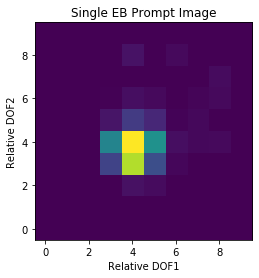

In [42]:
##-- Cell for plotting a single image. Can be skipped.

# # (X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_test_EB_Prompts_arr[2], cmap = "viridis", vmin=0, vmax=4)
# # plt.imshow(SigEB_rechits_arr, cmap = "viridis", vmin=0, vmax=3.75)
# # plt.imshow(SigEB_rechits_arr, cmap = "viridis")
# plt.imshow(SigEB_rechits_arr, cmap = "viridis")
plt.gca().invert_yaxis()
plt.title("Single EB Prompt Image")
plt.xlabel("Relative DOF1")
plt.ylabel("Relative DOF2")
# # plt.imshow(FakeEB_rechits_arr, cmap = "viridis")
# # plt.imshow(X_train_EB[1])
# # plt.imshow(X_train_EB[2])

Text(0, 0.5, 'Relative DOF2')

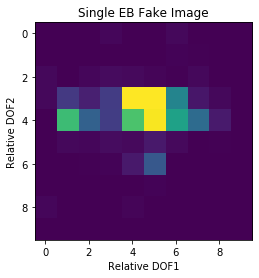

In [49]:
##-- Cell for plotting a single image. Can be skipped.

# # (X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_test_EB_Fakes_arr[3], cmap = "viridis", vmin=0, vmax=7)
# # plt.imshow(SigEB_rechits_arr, cmap = "viridis", vmin=0, vmax=3.75)
# # plt.imshow(SigEB_rechits_arr, cmap = "viridis")
# plt.imshow(SigEB_rechits_arr, cmap = "viridis")
# plt.gca().invert_yaxis()
plt.title("Single EB Fake Image")
plt.xlabel("Relative DOF1")
plt.ylabel("Relative DOF2")
# # plt.imshow(FakeEB_rechits_arr, cmap = "viridis")
# # plt.imshow(X_train_EB[1])
# # plt.imshow(X_train_EB[2])

In [50]:
##-- Reshape and categorize arrays. Format needed for CNN

X_train_EB_reshape = X_train_EB_arr.reshape(len(X_train_EB_arr),int(width),int(width),1)
Y_train_EB_reshape = to_categorical(Y_train_EB_arr)

X_valid_EB_reshape = X_valid_EB_arr.reshape(len(X_valid_EB_arr),int(width),int(width),1)
Y_valid_EB_reshape = to_categorical(Y_valid_EB_arr)

X_test_EB_Prompts_reshape = X_test_EB_Prompts_arr.reshape(len(X_test_EB_Prompts_arr),int(width),int(width),1)
Y_test_EB_Prompts_reshape = to_categorical(Y_test_EB_Prompts_arr)

X_test_EB_Fakes_reshape = X_test_EB_Fakes_arr.reshape(len(X_test_EB_Fakes_arr),int(width),int(width),1)
Y_test_EB_Fakes_reshape = to_categorical(Y_test_EB_Fakes_arr)

X_train_EE_reshape = X_train_EE_arr.reshape(len(X_train_EE_arr),int(width),int(width),1)
Y_train_EE_reshape = to_categorical(Y_train_EE_arr)

X_valid_EE_reshape = X_valid_EE_arr.reshape(len(X_valid_EE_arr),int(width),int(width),1)
Y_valid_EE_reshape = to_categorical(Y_valid_EE_arr)

X_test_EE_Prompts_reshape = X_test_EE_Prompts_arr.reshape(len(X_test_EE_Prompts_arr),int(width),int(width),1)
Y_test_EE_Prompts_reshape = to_categorical(Y_test_EE_Prompts_arr)

X_test_EE_Fakes_reshape = X_test_EE_Fakes_arr.reshape(len(X_test_EE_Fakes_arr),int(width),int(width),1)
Y_test_EE_Fakes_reshape = to_categorical(Y_test_EE_Fakes_arr)


In [54]:
##-- Model CNN for EB and EE

model_EB = Sequential()
model_EB.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(int(width),int(width),1)))
model_EB.add(Conv2D(32, kernel_size=3, activation='relu'))
model_EB.add(Flatten())
model_EB.add(Dense(2, activation='softmax')) # 1? 

model_EE = Sequential()
model_EE.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(int(width),int(width),1)))
model_EE.add(Conv2D(32, kernel_size=3, activation='relu'))
model_EE.add(Flatten())
model_EE.add(Dense(2, activation='softmax')) # 1? 

# model = Sequential([
#     Dense(16, input_shape=(1,), activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(2, activation='softmax') # output layer. In this example 2 for yes or no 
# ])

In [55]:
##-- Compile CNN Models


# These settings can be played with 

# model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_EB.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_EE.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
##-- Train models on training data, validate with validation data, for chosen number of Epochs

nEpochs = 2

model_EB.fit(X_train_EB_reshape, Y_train_EB_reshape, validation_data=(X_valid_EB_reshape, Y_valid_EB_reshape), epochs=nEpochs)

model_EE.fit(X_train_EE_reshape, Y_train_EE_reshape, validation_data=(X_valid_EE_reshape, Y_valid_EE_reshape), epochs=nEpochs)


W0415 06:30:30.964151 140317288761152 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0415 06:30:31.070157 140317288761152 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 320082 samples, validate on 106600 samples
Epoch 1/2
320082/320082 [==============================] - 167s 520us/step - loss: 0.3666 - acc: 0.8354 - val_loss: 0.3302 - val_acc: 0.8548
Epoch 2/2
320082/320082 [==============================] - 165s 516us/step - loss: 0.3293 - acc: 0.8561 - val_loss: 0.3272 - val_acc: 0.8600
Train on 265004 samples, validate on 88428 samples
Epoch 1/2
265004/265004 [==============================] - 139s 523us/step - loss: 0.4449 - acc: 0.7903 - val_loss: 0.4548 - val_acc: 0.7860
Epoch 2/2
265004/265004 [==============================] - 136s 513us/step - loss: 0.4256 - acc: 0.8015 - val_loss: 0.4252 - val_acc: 0.7990


2020-04-15 06:30:31.402395: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2020-04-15 06:30:31.425904: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2400150000 Hz
2020-04-15 06:30:31.428605: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x637be20 executing computations on platform Host. Devices:
2020-04-15 06:30:31.428655: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2020-04-15 06:30:31.825787: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via T

In [62]:
##-- Apply CNN output weights on test images 

EB_Prediction_Prompts = model_EB.predict(X_test_EB_Prompts_reshape)
EB_Prediction_Fakes = model_EB.predict(X_test_EB_Fakes_reshape)
EE_Prediction_Prompts = model_EE.predict(X_test_EE_Prompts_reshape)
EE_Prediction_Fakes = model_EE.predict(X_test_EE_Fakes_reshape)

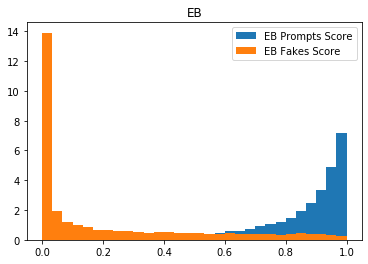

In [63]:
##-- Plot EB Results on Test data 

import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(EB_Prediction_Prompts[:,1], density=True, range=[0,1], bins=30, label="EB Prompts Score" )
plt.hist(EB_Prediction_Fakes[:,1], density=True, range=[0,1], bins=30, label="EB Fakes Score" )
plt.title("EB")
leg = plt.legend()


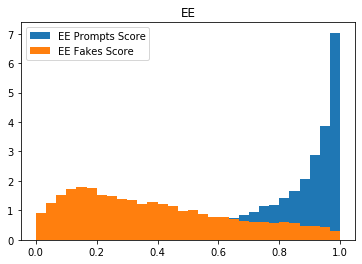

In [64]:
##-- Plot EE Results on Test data 

import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(EE_Prediction_Prompts[:,1], density=True, range=[0,1], bins=30, label="EE Prompts Score" )
plt.hist(EE_Prediction_Fakes[:,1], density=True, range=[0,1], bins=30, label="EE Fakes Score" )
plt.title("EE")
leg = plt.legend()

In [73]:
##--Plot ROC Curves 

outputLocation = "/eos/user/<letter>/<lxplusName>/www/<outputDirectory>/"

from array import array 

# Number of points 
n = 20

##############################################-- EB 

c10 = ROOT.TCanvas('c10','c10',800,600)
c11 = ROOT.TCanvas('c11','c11',800,600)

EB_Prompts_h = ROOT.TH1F("EB_Prompts_h","EB_Prompts_h",n,0,1)
EB_Fakes_h = ROOT.TH1F("EB_Fakes_h","EB_Fakes_h",n,0,1)

ROC_EB_x, ROC_EB_y = array( 'd' ), array( 'd' )

for item in range(0,n):
    IDcut = item / 10. 

for item in EB_Prediction_Prompts[:,1]:
    EB_Prompts_h.Fill(item)

for item in EB_Prediction_Fakes[:,1]:
    EB_Fakes_h.Fill(item) 
    
EB_Prompts_h.Scale(1/EB_Prompts_h.Integral(1,n))
EB_Fakes_h.Scale(1/EB_Fakes_h.Integral(1,n))
    
for IDcut_i in range(0,n):
#     IDcut = IDcut_i / 10.
    PromptInt = EB_Prompts_h.Integral(IDcut_i,n)
    FakeInt = EB_Fakes_h.Integral(IDcut_i,n)
    ROC_EB_y.append(PromptInt)
    ROC_EB_x.append(FakeInt)
#     print('ROC_x val:',PromptInt)
#     print('ROC_y val:',FakeInt)
    
ROC_g = ROOT.TGraph(n,ROC_EB_x,ROC_EB_y)  
    
ROC_g.SetLineColor( 2 )
ROC_g.SetLineWidth( 4 )
ROC_g.SetMarkerColor( 4 )
ROC_g.SetMarkerStyle( 21 )
ROC_g.SetTitle( 'Photon CNN ROC: EB' )
ROC_g.GetYaxis().SetTitle( 'True Positive Rate' )
ROC_g.GetXaxis().SetTitle( 'False Positive Rate' )

c10.cd()
ROC_g.Draw( 'ACP' )    
c10.SaveAs(outputLocation + "ROC_EB_g.png")    
    
c11.cd()
    
##############################################-- EE 
    
c10 = ROOT.TCanvas('c10','c10',800,600)

EE_Prompts_h = ROOT.TH1F("EE_Prompts_h","EE_Prompts_h",10,0,1)
EE_Fakes_h = ROOT.TH1F("EE_Fakes_h","EE_Fakes_h",10,0,1)

ROC_EE_x, ROC_EE_y = array( 'd' ), array( 'd' )

for item in range(0,n):
    IDcut = item / 10. 

for item in EE_Prediction_Prompts[:,1]:
    EE_Prompts_h.Fill(item)

for item in EE_Prediction_Fakes[:,1]:
    EE_Fakes_h.Fill(item) 
    
EE_Prompts_h.Scale(1/EE_Prompts_h.Integral(1,n))
EE_Fakes_h.Scale(1/EE_Fakes_h.Integral(1,n))
    
for IDcut_i in range(0,n):
#     IDcut = IDcut_i / 10.
    PromptInt = EE_Prompts_h.Integral(IDcut_i,n)
    FakeInt = EE_Fakes_h.Integral(IDcut_i,n)
    ROC_EE_y.append(PromptInt)
    ROC_EE_x.append(FakeInt)
#     print('ROC_x val:',PromptInt)
#     print('ROC_y val:',FakeInt)
    
ROC_EE_g = ROOT.TGraph(n,ROC_EE_x,ROC_EE_y)  
    
ROC_EE_g.SetLineColor( 2 )
ROC_EE_g.SetLineWidth( 4 )
ROC_EE_g.SetMarkerColor( 4 )
ROC_EE_g.SetMarkerStyle( 21 )
ROC_EE_g.SetTitle( 'Photon CNN ROC: EE' )
ROC_EE_g.GetYaxis().SetTitle( 'True Positive Rate' )
ROC_EE_g.GetXaxis().SetTitle( 'False Positive Rate' )

c10.cd()
ROC_EE_g.Draw( 'ACP' )    
c10.SaveAs(outputLocation + "ROC_EE_g.png")  
    

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c10
Warning in <TFile::Append>: Replacing existing TH1: EB_Prompts_h (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: EB_Fakes_h (Potential memory leak).
Info in <TCanvas::Print>: png file /eos/user/a/atishelm/www/PhotonIDStudy/Results/ROC_EB_g.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c10
Warning in <TFile::Append>: Replacing existing TH1: EE_Prompts_h (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: EE_Fakes_h (Potential memory leak).
Info in <TCanvas::Print>: png file /eos/user/a/atishelm/www/PhotonIDStudy/Results/ROC_EE_g.png has been created


('n prompt events:', 2345L)
('n fake events:', 1853L)
('len(X_train_EB) = ', 1963)
('len(X_valid_EB) = ', 652)
('len(X_test_EB_Prompts) = ', 158)
('len(X_test_EB_Fakes) = ', 133)
('len(X_train_EE) = ', 871)
('len(X_valid_EE) = ', 293)
('len(X_test_EE_Prompts) = ', 76)
('len(X_test_EE_Fakes) = ', 52)
Train on 1963 samples, validate on 652 samples
Epoch 1/100
1963/1963 [==============================] - 1s 747us/step - loss: 0.6266 - acc: 0.7010 - val_loss: 0.4846 - val_acc: 0.8282
Epoch 2/100
1963/1963 [==============================] - 1s 386us/step - loss: 0.4886 - acc: 0.7972 - val_loss: 0.4132 - val_acc: 0.8344
Epoch 3/100
1963/1963 [==============================] - 1s 437us/step - loss: 0.4524 - acc: 0.8125 - val_loss: 0.5234 - val_acc: 0.7025
Epoch 4/100
1963/1963 [==============================] - 1s 473us/step - loss: 0.4348 - acc: 0.8176 - val_loss: 0.3726 - val_acc: 0.8420
Epoch 5/100
1963/1963 [==============================] - 1s 437us/step - loss: 0.4393 - acc: 0.8110 - va

871/871 [==============================] - 0s 419us/step - loss: 0.3924 - acc: 0.8209 - val_loss: 0.4194 - val_acc: 0.8157
Epoch 17/100
871/871 [==============================] - 0s 373us/step - loss: 0.3330 - acc: 0.8507 - val_loss: 0.4114 - val_acc: 0.8020
Epoch 18/100
871/871 [==============================] - 0s 441us/step - loss: 0.3214 - acc: 0.8565 - val_loss: 0.4094 - val_acc: 0.8157
Epoch 19/100
871/871 [==============================] - 0s 355us/step - loss: 0.3743 - acc: 0.8381 - val_loss: 0.6438 - val_acc: 0.6758
Epoch 20/100
871/871 [==============================] - 0s 437us/step - loss: 0.3361 - acc: 0.8439 - val_loss: 0.3881 - val_acc: 0.8294
Epoch 21/100
871/871 [==============================] - 0s 466us/step - loss: 0.3476 - acc: 0.8519 - val_loss: 0.3665 - val_acc: 0.8430
Epoch 22/100
871/871 [==============================] - 0s 461us/step - loss: 0.3484 - acc: 0.8588 - val_loss: 0.4050 - val_acc: 0.8123
Epoch 23/100
871/871 [==============================] - 0s 46

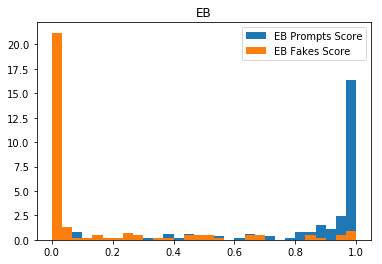

In [54]:
import ROOT
from ROOT import TFile, gROOT
import numpy as np 

import uproot

import keras
from keras import backend as K 
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers.core import Dense
from keras.layers.core import Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.datasets import mnist
from keras.utils import to_categorical

from os import environ
import matplotlib.pyplot as plt

environ['KERAS_BACKEND'] = 'theano'

gROOT.SetBatch(1)

# input_file = "/eos/user/a/atishelm/SWAN_projects/PhotonID/output_numEvent10000.root"
input_file = "/eos/user/a/atishelm/SWAN_projects/PhotonID/20kevtsAllPt.root"
# input_file = "/eos/user/a/atishelm/ntuples/PhotonCNN/20-40-hadded/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8_Hadded.root"

f = TFile(input_file)
Prompt_t = f.Get("photonViewDumper/trees/promptPhotons") 
Fake_t = f.Get("photonViewDumper/trees/fakePhotons") 

width = 10 
num_rec_hits = int(float(width)*float(width))

DOF1s, DOF2s, DOF3s, irechitEs = [], [], [], []

for i in range(int(num_rec_hits)):
    tmp_name = "DOF1s_"
    tmp_name += str(i)
    DOF1s.append(tmp_name)

    tmp_name = "DOF2s_"
    tmp_name += str(i)
    DOF2s.append(tmp_name)

    tmp_name = "DOF3s_"
    tmp_name += str(i)
    DOF3s.append(tmp_name)

    tmp_name = "recHit_"
    tmp_name += str(i)
    irechitEs.append(tmp_name)


X_train_EB = []
Y_train_EB = []

X_valid_EB = []
Y_valid_EB = []

X_test_EB_Prompts = []
Y_test_EB_Prompts = [] 
X_test_EB_Fakes = []
Y_test_EB_Fakes = [] 

X_train_EE = []
Y_train_EE = []

X_valid_EE = []
Y_valid_EE = []

X_test_EE_Prompts = []
Y_test_EE_Prompts = [] 
X_test_EE_Fakes = []
Y_test_EE_Fakes = [] 

# maxEvents=-1

nPromptEvents, nFakeEvents = Prompt_t.GetEntries(), Fake_t.GetEntries()

print('n prompt events:', nPromptEvents)
print('n fake events:', nFakeEvents)

# Run on all events, unless specified 
if(maxEvents==-1):
    totPromptEvents = nPromptEvents
    totFakeEvents = nFakeEvents
else:
    totPromptEvents = maxEvents 
    totFakeEvents = maxEvents

# print'totPromptEvents:',totPromptEvents
# print'totFakeEvents:',totFakeEvents

file = uproot.open(input_file)

# doPrompts = 0 

# if(args.doPrompts):

promptTree = file['photonViewDumper/trees/promptPhotons']
promptBranches = promptTree.arrays(namedecode='utf-8')

promptPhoObjDOF1Vals = promptBranches["DOF1"]
promptPhoObjDOF2Vals = promptBranches["DOF2"]
promptPhoObjDOF3Vals = promptBranches["DOF3"]

# Prompts     
    
# initialize an array for each entry 
# loop rec hits 
#  for each rec hit, fill appropriate array spot for all events 
#  append all arrays to train, validate, or test data::: sort based on EB,EE

# Create array for each event 
allPromptImages = []
allPromptImagesDOF3 = []
for iEvt in range(totPromptEvents):
    allPromptImages.append(
            [ [ 0 for i in range(width) ] for j in range(width) ]
        )
    allPromptImagesDOF3.append(-99)
    # allImages = [] # needs to be numpy array? 

for i_recHit in range(0,num_rec_hits):
#     if(i_recHit%10 == 0): print'On rechit:',i_recHit 
    # print'i_recHit:',i_recHit

    DOF1BranchName = DOF1s[i_recHit]
    DOF2BranchName = DOF2s[i_recHit]
    DOF3BranchName = DOF3s[i_recHit]
    recHitBranchName = irechitEs[i_recHit]

    DOF1Vals = promptBranches[DOF1BranchName]
    DOF2Vals = promptBranches[DOF2BranchName]
    DOF3Vals = promptBranches[DOF3BranchName]
    recHitVals = promptBranches[recHitBranchName]

    for iEvt in range(totPromptEvents):
        # print'iEvt%225000:',iEvt%225000
#         if(iEvt%225000 == 0): print'On event:',iEvt 
        recHitDOF1 = DOF1Vals[iEvt]
        recHitDOF2 = DOF2Vals[iEvt]
        recHitDOF3 = DOF3Vals[iEvt]
        recHitVal = recHitVals[iEvt]
        promptPhoDOF1 = promptPhoObjDOF1Vals[iEvt]
        promptPhoDOF2 = promptPhoObjDOF2Vals[iEvt]
        promptPhoDOF3 = promptPhoObjDOF3Vals[iEvt]

        if(recHitDOF1 == -9999): continue # in this case,  
#         if(args.EBOnly) and (promptPhoDOF3 != 0): continue # A check ONLY for looking at EB 

        # if(recHitVal == 0): continue # in this case, rechit val is already 0 for some reason            

        # print'promptPhoDOF1:',promptPhoDOF1
        # print'promptPhoDOF2:',promptPhoDOF2

        rel_dof1 = int(recHitDOF1 - promptPhoDOF1) + 4 
        rel_dof2 = int(recHitDOF2 - promptPhoDOF2) + 4 
        # print'rel_dof1:',rel_dof1
        # print'rel_dof2:',rel_dof2
        # print'recHitVal:',recHitVal

        # The question is now: how can you get rel_dof2 < 0: 
        # how can you get 
        # PROBLEM: There are entries where abs(DOF2s_0 - DOF2) > 5. and the rec hits 
        # are not necessarily 0. 
        # problem is DOF3 is not always 0 or +/- 1 

#         if(rel_dof2 < 0):
#             print'****rel_dof2 < 0****'
#             print'PREVIOUS energy:',recHitVals[iEvt-1]
#             print'iEvt:',iEvt
#             print'i_recHit:',i_recHit
#             print'rel_dof1:',rel_dof1
#             print'rel_dof2:',rel_dof2
#             print'recHitDOF1:',recHitDOF1                
#             print'recHitDOF2:',recHitDOF2  
#             print'recHitVal:',recHitVal              
#             print'promptPhoDOF1:',promptPhoDOF1
#             print'promptPhoDOF2:',promptPhoDOF2
        allPromptImages[iEvt][rel_dof1][rel_dof2] += recHitVal # update each event's i_recHit 
        if(allPromptImagesDOF3[iEvt]==-99): allPromptImagesDOF3[iEvt] = promptPhoDOF3
        # if(iEvt == 2): break



    # recHitImage = [ [ 0 for i in range(width) ] for j in range(width) ]

    # if(ie <= 0.675*(nPromptEvents)):        
    #     X_train_EB.append(PromptEB_rechits)
    #     Y_train_EB.append(1) # 1 = signal 

# print'allPromptImages[0]',allPromptImages[0] 
# print'allPromptImages[totPromptEvents-1]',allPromptImages[totPromptEvents-1]

for img_i,image in enumerate(allPromptImages):
    imgDOF3 = allPromptImagesDOF3[img_i]
    iPct1, iPct2 = 0.675, 0.9  

    # EB 
    if imgDOF3 == 0:
        if(img_i < iPct1*totPromptEvents):
            X_train_EB.append(image)
            Y_train_EB.append(1) # 1 = signal 
        elif( (img_i > iPct1*totPromptEvents) and (img_i <= iPct2*totPromptEvents) ):
            X_valid_EB.append(image)
            Y_valid_EB.append(1)
        else:
            X_test_EB_Prompts.append(image)
            Y_test_EB_Prompts.append(1)

    # EE
    elif imgDOF3 == -1 or imgDOF3 == 1:
        if(img_i < iPct1*totPromptEvents):
            X_train_EE.append(image)
            Y_train_EE.append(1) # 1 = signal 
        elif( (img_i > iPct1*totPromptEvents) and (img_i <= iPct2*totPromptEvents) ):
            X_valid_EE.append(image)
            Y_valid_EE.append(1)
        else:
            X_test_EE_Prompts.append(image)
            Y_test_EE_Prompts.append(1)

    else:
        print('ERROR')
        print('image DOF3 is neither EB nor EE.')
        print('Exiting')
        exit(0)

#####
# Fakes

fakeTree = file['photonViewDumper/trees/fakePhotons']
fakeBranches = fakeTree.arrays(namedecode='utf-8')

fakePhoObjDOF1Vals = fakeBranches["DOF1"]
fakePhoObjDOF2Vals = fakeBranches["DOF2"]
fakePhoObjDOF3Vals = fakeBranches["DOF3"]



# for iEvt in range(nPromptEvents):
    
# initialize an array for each entry 
# loop rec hits 
#  for each rec hit, fill appropriate array spot for all events 
#  append all arrays to train, validate, or test data::: sort based on EB,EE

# Create array for each event 
allFakeImages = []
allFakeImagesDOF3 = []
for iEvt in range(totFakeEvents):
    allFakeImages.append(
            [ [ 0 for i in range(width) ] for j in range(width) ]
        )
    allFakeImagesDOF3.append(-99)
    # allImages = [] # needs to be numpy array? 

for i_recHit in range(0,num_rec_hits):
#     if(i_recHit%10 == 0): print'On rechit:',i_recHit 
    # print'i_recHit:',i_recHit

    DOF1BranchName = DOF1s[i_recHit]
    DOF2BranchName = DOF2s[i_recHit]
    DOF3BranchName = DOF3s[i_recHit]
    recHitBranchName = irechitEs[i_recHit]

    DOF1Vals = fakeBranches[DOF1BranchName]
    DOF2Vals = fakeBranches[DOF2BranchName]
    DOF3Vals = fakeBranches[DOF3BranchName]
    recHitVals = fakeBranches[recHitBranchName]

    for iEvt in range(totFakeEvents):
#         if(iEvt%225000 == 0): print'On event:',iEvt 
        recHitDOF1 = DOF1Vals[iEvt]
        recHitDOF2 = DOF2Vals[iEvt]
        recHitDOF3 = DOF3Vals[iEvt]
        recHitVal = recHitVals[iEvt]
        fakePhoDOF1 = fakePhoObjDOF1Vals[iEvt]
        fakePhoDOF2 = fakePhoObjDOF2Vals[iEvt]
        fakePhoDOF3 = fakePhoObjDOF3Vals[iEvt]

        if(recHitDOF1 == -9999): continue # in this case,  
#         if(args.EBOnly) and (fakePhoDOF3 != 0): continue # A check ONLY for looking at EB 
        # if(recHitVal == 0): continue # in this case, rechit val is already 0 for some reason            

        # print'promptPhoDOF1:',promptPhoDOF1
        # print'promptPhoDOF2:',promptPhoDOF2

        rel_dof1 = int(recHitDOF1 - fakePhoDOF1) + 4 
        rel_dof2 = int(recHitDOF2 - fakePhoDOF2) + 4 
        # print'rel_dof1:',rel_dof1
        # print'rel_dof2:',rel_dof2
        # print'recHitVal:',recHitVal

        # The question is now: how can you get rel_dof2 < 0: 
        # how can you get 
        # PROBLEM: There are entries where abs(DOF2s_0 - DOF2) > 5. and the rec hits 
        # are not necessarily 0. 
        # problem is DOF3 is not always 0 or +/- 1 

#         if(rel_dof2 < 0):
#             print'****rel_dof2 < 0****'
#             print'PREVIOUS energy:',recHitVals[iEvt-1]
#             print'iEvt:',iEvt
#             print'i_recHit:',i_recHit
#             print'rel_dof1:',rel_dof1
#             print'rel_dof2:',rel_dof2
#             print'recHitDOF1:',recHitDOF1                
#             print'recHitDOF2:',recHitDOF2  
#             print'recHitVal:',recHitVal              
#             print'fakePhoDOF1:',fakePhoDOF1
#             print'fakePhoDOF2:',fakePhoDOF2
        allFakeImages[iEvt][rel_dof1][rel_dof2] += recHitVal # update each event's i_recHit 
        if(allFakeImagesDOF3[iEvt]==-99): allFakeImagesDOF3[iEvt] = fakePhoDOF3

        # if(iEvt == 2): break

    # recHitImage = [ [ 0 for i in range(width) ] for j in range(width) ]

    # if(ie <= 0.675*(nPromptEvents)):        
    #     X_train_EB.append(PromptEB_rechits)
    #     Y_train_EB.append(1) # 1 = signal 

# print'allPromptImages[0]',allPromptImages[0] 
# print'allFakeImages[totFakeEvents-1]',allFakeImages[totFakeEvents-1]


for img_i,image in enumerate(allFakeImages):
    imgDOF3 = allFakeImagesDOF3[img_i]
    iPct1, iPct2 = 0.675, 0.9  

    # EB 
    if imgDOF3 == 0:
        if(img_i < iPct1*totFakeEvents):
            X_train_EB.append(image)
            Y_train_EB.append(0) # 1 = signal 
        elif( (img_i > iPct1*totFakeEvents) and (img_i <= iPct2*totFakeEvents) ):
            X_valid_EB.append(image)
            Y_valid_EB.append(0)
        else:
            X_test_EB_Fakes.append(image)
            Y_test_EB_Fakes.append(0)

    # EE
    elif imgDOF3 == -1 or imgDOF3 == 1:
        if(img_i < iPct1*totFakeEvents):
            X_train_EE.append(image)
            Y_train_EE.append(0) # 1 = signal 
        elif( (img_i > iPct1*totFakeEvents) and (img_i <= iPct2*totFakeEvents) ):
            X_valid_EE.append(image)
            Y_valid_EE.append(0)
        else:
            X_test_EE_Fakes.append(image)
            Y_test_EE_Fakes.append(0)

    else:
        print('ERROR')
        print('image DOF3 is neither EB nor EE.')
        print('Exiting')
        exit(0)




X_train_EB = np.array(X_train_EB)
X_valid_EB = np.array(X_valid_EB)

Y_train_EB = np.array(Y_train_EB)
Y_valid_EB = np.array(Y_valid_EB)

X_test_EB_Prompts = np.array(X_test_EB_Prompts)
Y_test_EB_Prompts = np.array(Y_test_EB_Prompts)

X_test_EB_Fakes = np.array(X_test_EB_Fakes)
Y_test_EB_Fakes = np.array(Y_test_EB_Fakes)

X_train_EE = np.array(X_train_EE)
X_valid_EE = np.array(X_valid_EE)

Y_train_EE = np.array(Y_train_EE)
Y_valid_EE = np.array(Y_valid_EE)

X_test_EE_Prompts = np.array(X_test_EE_Prompts)
Y_test_EE_Prompts = np.array(Y_test_EE_Prompts)

X_test_EE_Fakes = np.array(X_test_EE_Fakes)
Y_test_EE_Fakes = np.array(Y_test_EE_Fakes)

printLengths = 1
printArrays = 0


if(printLengths):
    print('len(X_train_EB) = ',len(X_train_EB))
    print('len(X_valid_EB) = ',len(X_valid_EB))
    print('len(X_test_EB_Prompts) = ',len(X_test_EB_Prompts))
    print('len(X_test_EB_Fakes) = ',len(X_test_EB_Fakes))
    print('len(X_train_EE) = ',len(X_train_EE))
    print('len(X_valid_EE) = ',len(X_valid_EE))
    print('len(X_test_EE_Prompts) = ',len(X_test_EE_Prompts))
    print('len(X_test_EE_Fakes) = ',len(X_test_EE_Fakes))
    EB_sum = len(X_train_EB) + len(X_valid_EB) + len(X_test_EB_Prompts) + len(X_test_EB_Fakes)
    EE_sum = len(X_train_EE) + len(X_valid_EE) + len(X_test_EE_Prompts) + len(X_test_EE_Fakes)
#     print'EB sum: ',EB_sum
#     print'EE sum: ',EE_sum
    total = EB_sum + EE_sum
    # print'Total:',total 
#     print'-----'
#     print'n prompt events:', nPromptEvents
#     print'n fake events:', nFakeEvents
    treeTotal = nPromptEvents + nFakeEvents
#     print'Total:',total 
#     print'Tree Total:',treeTotal
    
    assert(treeTotal==total) # check that all events were placed into Prompt/Fake, EB/EE, Train/Valid/Test categories.

if(printArrays):
    print('Y_train_EB = ',Y_train_EB)
    print('Y_valid_EB = ',Y_valid_EB)
    print('Y_test_EB_Prompts = ',Y_test_EB_Prompts)
    print('Y_test_EB_Fakes = ',Y_test_EB_Fakes)
    
    print('Y_train_EE = ',Y_train_EE)
    print('Y_valid_EE = ',Y_valid_EE)
    print('Y_test_EE_Prompts = ',Y_test_EE_Prompts)
    print('Y_test_EE_Fakes = ',Y_test_EE_Fakes)    



X_train_EB = X_train_EB.reshape(len(X_train_EB),int(width),int(width),1)
Y_train_EB = to_categorical(Y_train_EB)

X_valid_EB = X_valid_EB.reshape(len(X_valid_EB),int(width),int(width),1)
Y_valid_EB = to_categorical(Y_valid_EB)
# print plt.imshow(X_test[0])

X_test_EB_Prompts = X_test_EB_Prompts.reshape(len(X_test_EB_Prompts),int(width),int(width),1)
Y_test_EB_Prompts = to_categorical(Y_test_EB_Prompts)

X_test_EB_Fakes = X_test_EB_Fakes.reshape(len(X_test_EB_Fakes),int(width),int(width),1)
Y_test_EB_Fakes = to_categorical(Y_test_EB_Fakes)

X_train_EE = X_train_EE.reshape(len(X_train_EE),int(width),int(width),1)
Y_train_EE = to_categorical(Y_train_EE)

X_valid_EE = X_valid_EE.reshape(len(X_valid_EE),int(width),int(width),1)
Y_valid_EE = to_categorical(Y_valid_EE)
# print plt.imshow(X_test[0])

X_test_EE_Prompts = X_test_EE_Prompts.reshape(len(X_test_EE_Prompts),int(width),int(width),1)
Y_test_EE_Prompts = to_categorical(Y_test_EE_Prompts)

X_test_EE_Fakes = X_test_EE_Fakes.reshape(len(X_test_EE_Fakes),int(width),int(width),1)
Y_test_EE_Fakes = to_categorical(Y_test_EE_Fakes)


model_EB = Sequential()
model_EE = Sequential()

model_EB.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(int(width),int(width),1)))
model_EB.add(Conv2D(32, kernel_size=3, activation='relu'))
model_EB.add(Flatten())
model_EB.add(Dense(2, activation='softmax'))

model_EE.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(int(width),int(width),1)))
model_EE.add(Conv2D(32, kernel_size=3, activation='relu'))
model_EE.add(Flatten())
model_EE.add(Dense(2, activation='softmax'))

# model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_EB.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_EE.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_EB.fit(X_train_EB, Y_train_EB, validation_data=(X_valid_EB, Y_valid_EB), epochs=100)

model_EE.fit(X_train_EE, Y_train_EE, validation_data=(X_valid_EE, Y_valid_EE), epochs=100)

EB_Prediction_Prompts = model_EB.predict(X_test_EB_Prompts)
EB_Prediction_Fakes = model_EB.predict(X_test_EB_Fakes)
EE_Prediction_Prompts = model_EE.predict(X_test_EE_Prompts)
EE_Prediction_Fakes = model_EE.predict(X_test_EE_Fakes)

%matplotlib inline
plt.hist(EB_Prediction_Prompts[:,1], density=True, range=[0,1], bins=30, label="EB Prompts Score" )
plt.hist(EB_Prediction_Fakes[:,1], density=True, range=[0,1], bins=30, label="EB Fakes Score" )
plt.title("EB")
leg = plt.legend()

# %matplotlib inline
# plt.hist(EE_Prediction_Prompts[:,1], density=True, range=[0,1], bins=30, label="EE Prompts Score" )
# plt.hist(EE_Prediction_Fakes[:,1], density=True, range=[0,1], bins=30, label="EE Fakes Score" )
# plt.title("EE")
# leg = plt.legend()

# print('Exiting')
# exit(0) 

In [ ]:

%matplotlib inline
plt.hist(EB_Prediction_Prompts[:,1], density=True, range=[0,1], bins=30, label="EB Prompts Score" )
plt.hist(EB_Prediction_Fakes[:,1], density=True, range=[0,1], bins=30, label="EB Fakes Score" )
plt.title("EB")
leg = plt.legend()

In [ ]:
## -- Saving extra code 

# if(not useupRoot):
print('---Not Using uproot---')
print('---Scanning Prompts---')

for ie,entry in enumerate(Prompt_t):
#         print'promupt ie:',ie 

#         if ie%500 == 0: print'On event:',ie
#         if ie%1000 == 0: print('%f Percent Done'%(float(ie)/float(nPromptEvents))*100.)
#         if ie == nevents: 
#             print'exiting'
#         break 

    # Given entry has one photon object with some DOF1,2,3 
    pho_object_DOF1 = eval("Prompt_t.DOF1")
    pho_object_DOF2 = eval("Prompt_t.DOF2")
    pho_object_DOF3 = eval("Prompt_t.DOF3")

#     print'pho_object_DOF3:',pho_object_DOF3

    # EB Prompt 
    if pho_object_DOF3 == 0:
#         print'Prompt EB'
        PromptEB_rechits = [ [ 0 for i in range(width) ] for j in range(width) ]
        NPromptEB_rechits = [ [ 0 for i in range(width) ] for j in range(width) ]

        for rh in range(0,num_rec_hits):
            # Given entry has many rec hits to make map surrounding one photon object position 

            DOF1_eval = "Prompt_t." + DOF1s[rh]
            DOF2_eval = "Prompt_t." + DOF2s[rh]
            DOF3_eval = "Prompt_t." + DOF3s[rh]
            recHitEeval = "Prompt_t." + irechitEs[rh]

            DOF1 = eval(DOF1_eval)
            DOF2 = eval(DOF2_eval)
            DOF3 = eval(DOF3_eval)
            recHitE = eval(recHitEeval)

            if DOF1 is not -9999:
                # if DOF3 == -1:  
                    # sigRecHitMapEEm.Fill(DOF1,DOF2,recHitE)
                if DOF3 == 0: 
                    rel_dof1 = int((DOF1 - pho_object_DOF1)) + 4 # 4 for width 5   
                    rel_dof2 = int((DOF2 - pho_object_DOF2)) + 4                         
#                         rel_dof1 = int((DOF1 - pho_object_DOF1)) + 14  
#                         rel_dof2 = int((DOF2 - pho_object_DOF2)) + 14  
                    PromptEB_rechits[rel_dof1][rel_dof2] += recHitE  
                    NPromptEB_rechits[rel_dof1][rel_dof2] += 1 # for occupancy 

        # Choose set to add entry to         
        # Take first (currently ordered) 67.5% for training, next 22.5% for validation, rest for test set 

        if(ie <= 0.675*(nPromptEvents)):        
            X_train_EB.append(PromptEB_rechits)
            Y_train_EB.append(1) # 1 = signal 

#         elif(ie <= 0.225*(nPromptEvents)):
        elif( (ie > 0.675*(nPromptEvents)) and (ie <=0.9*nPromptEvents) ):
            X_valid_EB.append(PromptEB_rechits)
            Y_valid_EB.append(1)

        else:
            X_test_EB_Prompts.append(PromptEB_rechits)
            Y_test_EB_Prompts.append(1) # 1 = signal         

    # EE Prompt
    else: 
#         print'prompt EfffsE'
        PromptEE_rechits = [ [ 0 for i in range(width) ] for j in range(width) ]
#             NPromptEE_rechits = [ [ 0 for i in range(width) ] for j in range(width) ]   

        for rh in range(0,num_rec_hits):
            # Given entry has many rec hits to make map surrounding one photon object position 

            DOF1_eval = "Prompt_t." + DOF1s[rh]
            DOF2_eval = "Prompt_t." + DOF2s[rh]
            DOF3_eval = "Prompt_t." + DOF3s[rh]
            recHitEeval = "Prompt_t." + irechitEs[rh]

            DOF1 = eval(DOF1_eval)
            DOF2 = eval(DOF2_eval)
            DOF3 = eval(DOF3_eval)
            recHitE = eval(recHitEeval)
#             print'DOF1:',DOF1
#             print'DOF1 is not -9999:',DOF1 is not -9999
#             if DOF1 is not -9999.0:
            if DOF1 != -9999.0:
                # if DOF3 == -1:  
                    # sigRecHitMapEEm.Fill(DOF1,DOF2,recHitE)
                if DOF3 != 0: 
                    rel_dof1 = int((DOF1 - pho_object_DOF1)) + 4 # 4 for width 5   
                    rel_dof2 = int((DOF2 - pho_object_DOF2)) + 4                         
#                         rel_dof1 = int((DOF1 - pho_object_DOF1)) + 14  
#                         rel_dof2 = int((DOF2 - pho_object_DOF2)) + 14  
#                     print"DOF1: %s. DOF2: %s"%(str(DOF1),str(DOF2))
#                     print'rel_dof1:',rel_dof1
#                     print'rel_dof2:',rel_dof2
                    PromptEE_rechits[rel_dof1][rel_dof2] += recHitE  
#                         NPromptEE_rechits[rel_dof1][rel_dof2] += 1 # for occupancy 

        # Choose set to add entry to         
        # Take first (currently ordered) 67.5% for training, next 22.5% for validation, rest for test set 

        if(ie <= 0.675*(nPromptEvents)):        
            X_train_EE.append(PromptEE_rechits)
            Y_train_EE.append(1) # 1 = signal 

#         elif(ie <= 0.225*(nPromptEvents)):
        elif( (ie > 0.675*(nPromptEvents)) and (ie <=0.9*nPromptEvents) ):
            X_valid_EE.append(PromptEE_rechits)
            Y_valid_EE.append(1)

        else:
            X_test_EE_Prompts.append(PromptEE_rechits)
            Y_test_EE_Prompts.append(1) # 1 = signal 

print('---Scanning Fakes---')
for ie,entry in enumerate(Fake_t):

#         if ie%500 == 0: print'On event:',ie 
#         if ie%1000 == 0: print('%f Percent Done'%(float(ie)/float(nPromptEvents))*100.)

    # Given entry has one photon object with some DOF1,2,3 
    pho_object_DOF1 = eval("Fake_t.DOF1")
    pho_object_DOF2 = eval("Fake_t.DOF2")
    pho_object_DOF3 = eval("Fake_t.DOF3")

    if pho_object_DOF3 == 0:
        FakeEB_rechits = [ [ 0 for i in range(width) ] for j in range(width) ]
#             NFakeEB_rechits = [ [ 0 for i in range(width) ] for j in range(width) ]

        for rh in range(0,num_rec_hits):
            # Given entry has many rec hits to make map surrounding one photon object position 

            DOF1_eval = "Fake_t." + DOF1s[rh]
            DOF2_eval = "Fake_t." + DOF2s[rh]
            DOF3_eval = "Fake_t." + DOF3s[rh]
            recHitEeval = "Fake_t." + irechitEs[rh]

            DOF1 = eval(DOF1_eval)
            DOF2 = eval(DOF2_eval)
            DOF3 = eval(DOF3_eval)
            recHitE = eval(recHitEeval)

            if DOF1 is not -9999:
                # if DOF3 == -1:  
                    # sigRecHitMapEEm.Fill(DOF1,DOF2,recHitE)
                if DOF3 == 0:  
                    rel_dof1 = int((DOF1 - pho_object_DOF1)) + 4  
                    rel_dof2 = int((DOF2 - pho_object_DOF2)) + 4  
                    FakeEB_rechits[rel_dof1][rel_dof2] += recHitE  
#                         FakeEB_rechits[rel_dof1][rel_dof2] += 1 

        # Choose set to add entry to         
        # Take first (currently ordered) 67.5% for training, next 22.5% for validation, rest for test set 

        if(ie <= 0.675*(nFakeEvents)):        
            X_train_EB.append(FakeEB_rechits)
            Y_train_EB.append(0) # 0 = Fake 

#         elif(ie <= 0.225*(nFakeEvents)):
        elif( (ie > 0.675*(nFakeEvents)) and (ie <=0.9*nFakeEvents) ):
            X_valid_EB.append(FakeEB_rechits)
            Y_valid_EB.append(0)

        else:
            X_test_EB_Fakes.append(FakeEB_rechits)
            Y_test_EB_Fakes.append(0) # 0 = Fake                     

    # EE Fake 
    else:

        # Given entry has one photon object with some DOF1,2,3 
        pho_object_DOF1 = eval("Fake_t.DOF1")
        pho_object_DOF2 = eval("Fake_t.DOF2")
        pho_object_DOF3 = eval("Fake_t.DOF3")

        if pho_object_DOF3 != 0:
            FakeEE_rechits = [ [ 0 for i in range(width) ] for j in range(width) ]
            NFakeEE_rechits = [ [ 0 for i in range(width) ] for j in range(width) ]

            for rh in range(0,num_rec_hits):
                # Given entry has many rec hits to make map surrounding one photon object position 

                DOF1_eval = "Fake_t." + DOF1s[rh]
                DOF2_eval = "Fake_t." + DOF2s[rh]
                DOF3_eval = "Fake_t." + DOF3s[rh]
                recHitEeval = "Fake_t." + irechitEs[rh]

                DOF1 = eval(DOF1_eval)
                DOF2 = eval(DOF2_eval)
                DOF3 = eval(DOF3_eval)
                recHitE = eval(recHitEeval)

#                 if int(DOF1) is not -9999:
                if DOF1 != -9999.0:
                    # if DOF3 == -1:  
                        # sigRecHitMapEEm.Fill(DOF1,DOF2,recHitE)
                    if DOF3 != 0:  
                        rel_dof1 = int((DOF1 - pho_object_DOF1)) + 4  
                        rel_dof2 = int((DOF2 - pho_object_DOF2)) + 4  

                        FakeEE_rechits[rel_dof1][rel_dof2] += recHitE  
#                             FakeEE_rechits[rel_do
# f1][rel_dof2] += 1 

            # Choose set to add entry to         
            # Take first (currently ordered) 67.5% for training, next 22.5% for validation, rest for test set 

            if(ie <= 0.675*(nFakeEvents)):        
                X_train_EE.append(FakeEE_rechits)
                Y_train_EE.append(0) # 0 = Fake 

#             elif(ie <= 0.225*(nFakeEvents)):
            elif( (ie > 0.675*(nFakeEvents)) and (ie <=0.9*nFakeEvents) ):
                X_valid_EE.append(FakeEE_rechits)
                Y_valid_EE.append(0)

            else:
                X_test_EE_Fakes.append(FakeEE_rechits)
                Y_test_EE_Fakes.append(0) # 0 = Fake 
print('DONE')

##-----------------------------------------------------------------------------
    